# EDA for VinBigData Chest X-Ray challenge

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/Colab\ Notebooks/kaggle
    from setup_colab import setup_colab_for_kaggle, WORK_FOLDER, OUTPUT_FOLDER, dump_dataset_metadata
    setup_colab_for_kaggle(check_env=False, local_working=True)
except:
    print("Not in Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Content of Drive Kaggle data dir (/content/drive/MyDrive/kaggle): ['/content/drive/MyDrive/kaggle/input', '/content/drive/MyDrive/kaggle/working', '/content/drive/MyDrive/kaggle/.ipynb_checkpoints', '/content/drive/MyDrive/kaggle/output']
Content of Kaggle data dir (/kaggle): ['/kaggle/output', '/kaggle/working', '/kaggle/input']
Content of Kaggle data subdir (/kaggle/input): ['/kaggle/input/cassava-model', '/kaggle/input/cassava-leaf-disease-classification', '/kaggle/input/googlebitemperedloss', '/kaggle/input/vbdyolo', '/kaggle/input/.ipynb_checkpoints', '/kaggle/input/vinbigdata', '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection', '/kaggle/input/vinbigdata-chest-xray-origi

In [ ]:
import os
import json

from IPython.display import clear_output

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

INPUT_FOLDER_DATA = WORK_FOLDER / "vinbigdata-chest-xray-abnormalities-detection"
INPUT_FOLDER_PNG = WORK_FOLDER / "vinbigdata-chest-xray-original-png"

## Download data

In [ ]:
!pip install git+https://github.com/Witalia008/kaggle-api.git@witalia-main
clear_output()

Download the competition dataset's `train.csv`, `sample_submission.csv`, and 10 sample `.dicom` files for `train` subset.

In [ ]:
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train.csv -p {INPUT_FOLDER_DATA} --unzip
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f sample_submission.csv -p {INPUT_FOLDER_DATA} --unzip
sample_train_images = [
    "000434271f63a053c4128a0ba6352c7f",
    "00053190460d56c53cc3e57321387478",
    "0005e8e3701dfb1dd93d53e2ff537b6e",
    "0006e0a85696f6bb578e84fafa9a5607",
    "0007d316f756b3fa0baea2ff514ce945",
    "000ae00eb3942d27e0b97903dd563a6e",
    "000d68e42b71d3eac10ccc077aba07c1",
    "00150343289f317a0ad5629d5b7d9ef9",
    "00176f7e1b1cb835123f95960b9a9efd",
    "001d127bad87592efe45a5c7678f8b8d",
]
for image_id in sample_train_images:
    !kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train/{image_id}.dicom -p {INPUT_FOLDER_DATA}/train --unzip --quiet

  0% 0.00/1.79M [00:00<?, ?B/s]
100% 1.79M/1.79M [00:00<00:00, 156MB/s]
  0% 0.00/135k [00:00<?, ?B/s]
100% 135k/135k [00:00<00:00, 63.6MB/s]


Download the dataset with original PNG images

In [ ]:
!kaggle datasets download corochann/vinbigdata-chest-xray-original-png -p {INPUT_FOLDER_PNG} --unzip

100% 46.5G/46.5G [08:51<00:00, 113MB/s]
100% 46.5G/46.5G [08:51<00:00, 93.9MB/s]


## Load data and check some basic counts

### Check number of labels and images, peek inside the data

In [ ]:
train_data = pd.read_csv(os.path.join(INPUT_FOLDER_DATA, "train.csv"))

# Add metadata (with image sizes)
train_meta = pd.read_csv(os.path.join(INPUT_FOLDER_PNG, "train_meta.csv"))
train_data = pd.merge(train_data, train_meta, left_on="image_id", right_on="image_id")

# NOTE: For some reason, dim0 is in fact y-axis, and dim1 is x-axis!
train_data[["dim0", "dim1"]] = train_data[["dim1", "dim0"]]

# Reformat columns
train_data["rad_id"] = train_data["rad_id"].apply(lambda rid: f"R{int(rid[1:]):02d}")  # Add leading zero to rad_id, to sort better

# Retrieve abnormal data
train_data_abnormal = train_data[train_data.class_name != "No finding"]

class_id_map = train_data[["class_name", "class_id"]].groupby(["class_name"]).agg("mean").to_dict()["class_id"]
class_name_map = {value:key for key, value in class_id_map.items()}
print(json.dumps(class_name_map, indent=4))

print(f"Total entries: {len(train_data)}")
print(f"Total images: {train_data.image_id.nunique()}")
train_data.head()

{
    "0": "Aortic enlargement",
    "1": "Atelectasis",
    "2": "Calcification",
    "3": "Cardiomegaly",
    "4": "Consolidation",
    "5": "ILD",
    "6": "Infiltration",
    "7": "Lung Opacity",
    "14": "No finding",
    "8": "Nodule/Mass",
    "9": "Other lesion",
    "10": "Pleural effusion",
    "11": "Pleural thickening",
    "12": "Pneumothorax",
    "13": "Pulmonary fibrosis"
}
Total entries: 67914
Total images: 15000


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN,2332,2580
2,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN,2332,2580
3,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R07,NaN,NaN,NaN,NaN,2954,3159
4,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R13,NaN,NaN,NaN,NaN,2954,3159


## Labelling stats

### See class counts

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Abnormalities frequencies')

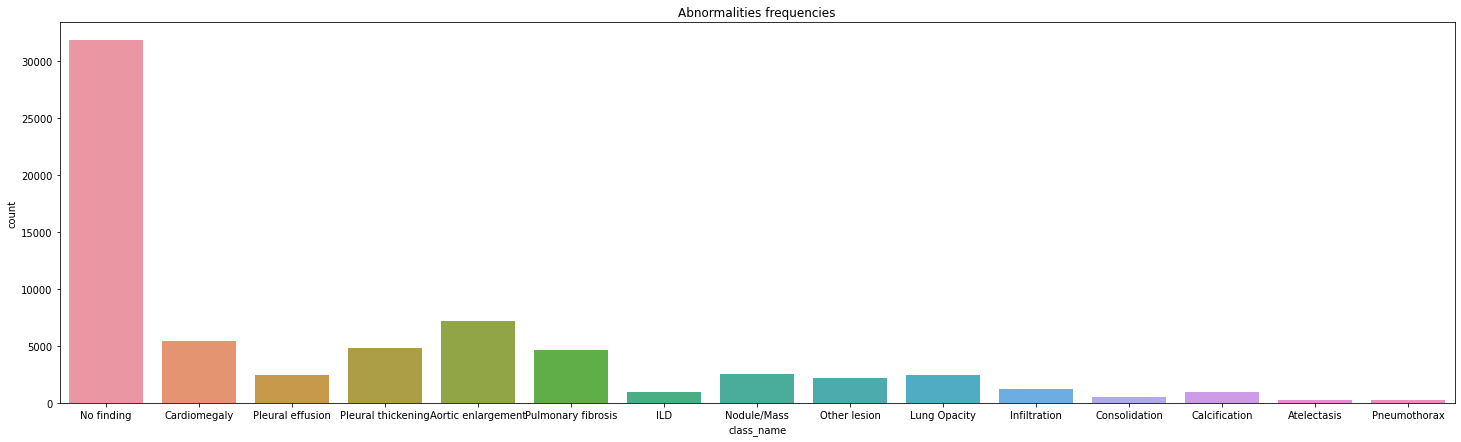

In [ ]:
_, ax = plt.subplots(figsize=(25, 7))
sns.countplot(train_data["class_name"], ax=ax).set_title("Abnormalities frequencies")

In [ ]:
image_classes = train_data[["image_id", "class_name"]]
count_nofinding = image_classes[image_classes["class_name"] == "No finding"].groupby(["image_id"]).agg(["count"])
print(f"Total no finding: {len(count_nofinding)}")
count_nofind_disagree = count_nofinding[count_nofinding[("class_name", "count")] != 3]
print(f"Total no finding disagreements (not all 3 identified no find): {len(count_nofind_disagree)}")

Total no finding: 10606
Total no finding disagreements (not all 3 identified no find): 0


* A large class imbalance towards "No finding".
* There's no case where some radiologist would not find anything when others would.

### Counts of labels per image and diseases per image

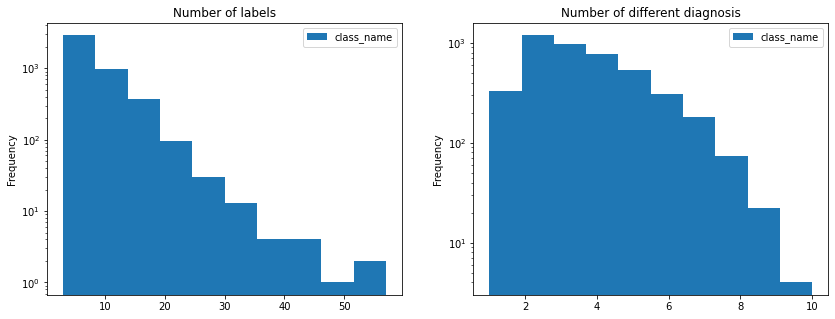

In [ ]:
labels_per_image = train_data_abnormal[["image_id", "class_name"]]
labels_per_image = labels_per_image.groupby(["image_id"]).agg("count")
diseases_per_image = train_data_abnormal[["image_id", "class_name"]].groupby(["image_id"]).agg(lambda class_names: len(set(class_names)))
_, ax = plt.subplots(1, 2, figsize=(14, 5))
labels_per_image.plot(kind="hist", logy=True, ax=ax[0], title="Number of labels")
diseases_per_image.plot(kind="hist", logy=True, ax=ax[1], title="Number of different diagnosis")

* There could be up to ~55 labels per image.
* Up to 10 different diseases.
* The larger number of abnormalities, the rarer it is.

## Stats for radiologists

### Count of labels for each radiologist (abnormal)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


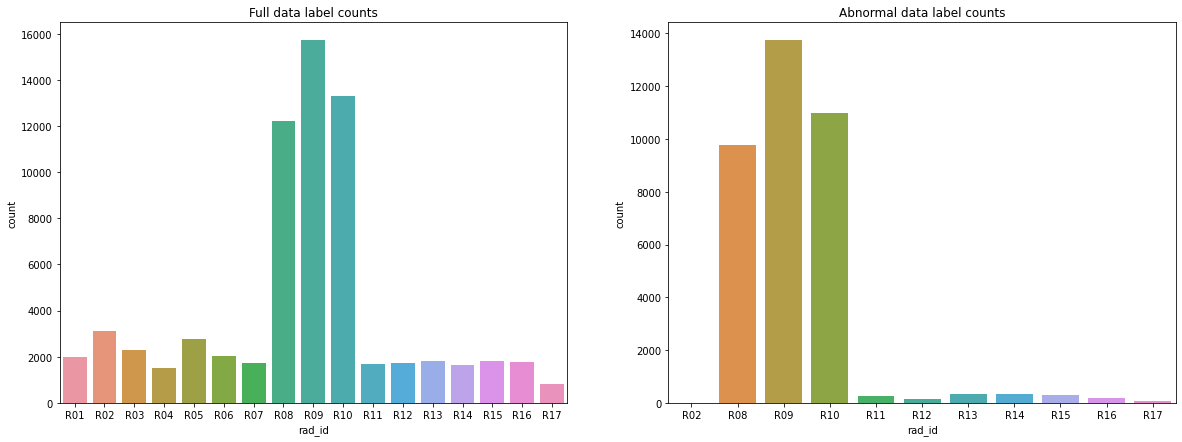

In [ ]:
def plot_label_counts(ax, data, title):
    sns.countplot(data["rad_id"].sort_values(), ax=ax).set_title(title)

_, ax = plt.subplots(1, 2, figsize=(20, 7))
plot_label_counts(ax[0], train_data, "Full data label counts")
plot_label_counts(ax[1], train_data_abnormal, "Abnormal data label counts")

### Image counts for each radiologist (abnormal)

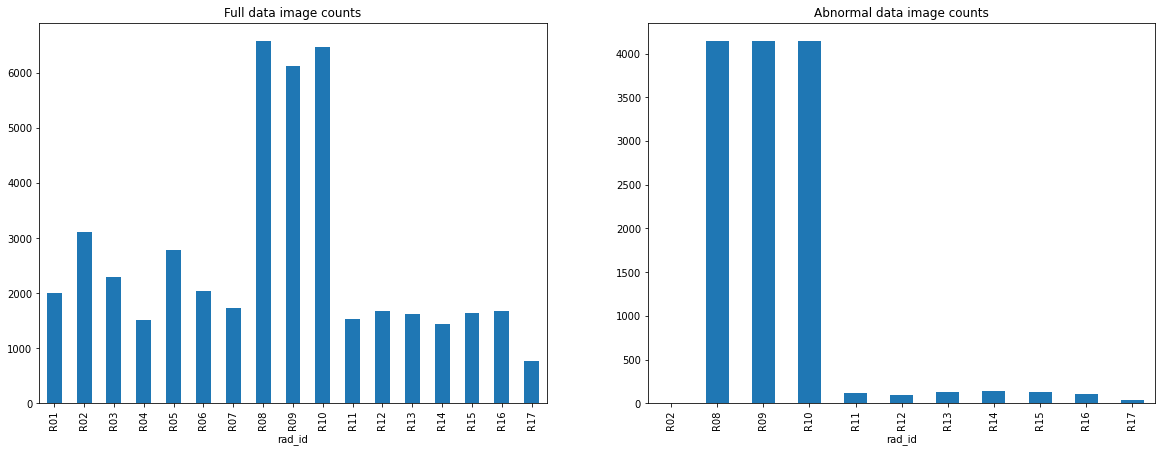

In [ ]:
def plot_image_counts(ax, data, title):
    data = data[["image_id", "rad_id"]].groupby(["rad_id"]).image_id.nunique()
    data.sort_index().plot(kind="bar", ax=ax).set_title(title)

_, ax = plt.subplots(1, 2, figsize=(20, 7))
plot_image_counts(ax[0], train_data, "Full data image counts")
plot_image_counts(ax[1], train_data_abnormal, "Abnormal data image counts")

* R9, R10, R8 all have 2x images labelled than the next highest labeller (R2), however, their label count is 4x higher than R2.
* However, looking only at abnormal data, these three were labelling most of the abnormal data. Within abnormal data, R9 seems to have a bit more labels than the other two.

### Average label count per radiologist, per disease

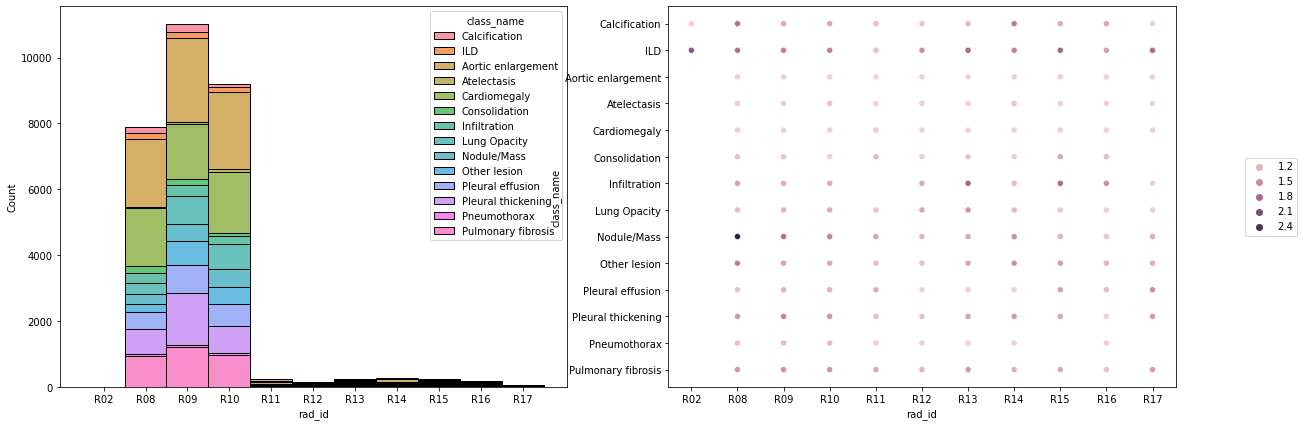

In [ ]:
rad_stats_labels = train_data_abnormal[["image_id", "rad_id", "class_name"]]
rad_stats_labels = rad_stats_labels.groupby(["rad_id", "class_name"]).image_id.agg(lambda images: images.value_counts().mean())
_, ax = plt.subplots(1, 2, figsize=(20, 7))
g = sns.scatterplot(data=rad_stats_labels.sort_index().reset_index(), x="rad_id", y="class_name", hue="image_id", ax=ax[1])
g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

rad_stats_labels = train_data_abnormal[["image_id", "rad_id", "class_name"]]
rad_stats_labels = rad_stats_labels.groupby(["rad_id", "class_name"]).image_id.agg(lambda images: images.nunique())
sns.histplot(data=rad_stats_labels.reset_index(), x="rad_id", hue="class_name", weights="image_id", multiple="stack", ax=ax[0])

* R1, R3, R4, R5, R6, R7 only have labels "No finding". R2 only labelled 2 diseases (in addition to "No finding" labels).
* R8 also seems to have abnormally large amount of labels per image for "Nodule/Mass" class.



### Who labels together

In [ ]:
label_triplets = train_data[["rad_id", "image_id"]].groupby("image_id")["rad_id"].apply(lambda rads: ",".join(sorted(set(rads))))
label_triplets = label_triplets.reset_index().groupby(["rad_id"]).agg("count").sort_values(by="image_id", ascending=False)
label_triplets.head()

,image_id
rad_id,
"R08,R09,R10",5501
"R02,R03,R05",115
"R01,R02,R03",104
"R02,R03,R06",100
"R12,R13,R16",99


* R8, R9, R10 seem to work together and labelled a lot of images together.

## Stats for diseases and their locations

### Bounding box (bbox) size distributions

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1,x_min_norm,x_max_norm,y_min_norm,y_max_norm,bbox_width_norm,bbox_height_norm,bbox_size_norm
34,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R15,161.0,56.0,2117.0,2213.0,2285,2555,0.070460,0.926477,0.021918,0.866145,0.856018,0.844227,0.722673
35,0c7a38f293d5f5e4846aa4ca6db4daf1,Other lesion,9,R15,161.0,56.0,2117.0,2213.0,2285,2555,0.070460,0.926477,0.021918,0.866145,0.856018,0.844227,0.722673
6946,6d5acf3f8a973a26844d617fffe72998,Nodule/Mass,8,R10,124.0,339.0,2238.0,2316.0,2304,2880,0.053819,0.971354,0.117708,0.804167,0.917535,0.686458,0.629849
10975,0d30dc1e0070e7a934f39452e3ad3b83,Other lesion,9,R09,43.0,29.0,2034.0,2327.0,2080,2344,0.020673,0.977885,0.012372,0.992747,0.957212,0.980375,0.938427
33178,e4a528876744e3a37158645935028c57,ILD,5,R17,112.0,387.0,1992.0,2444.0,2093,2617,0.053512,0.951744,0.147879,0.933894,0.898232,0.786015,0.706024


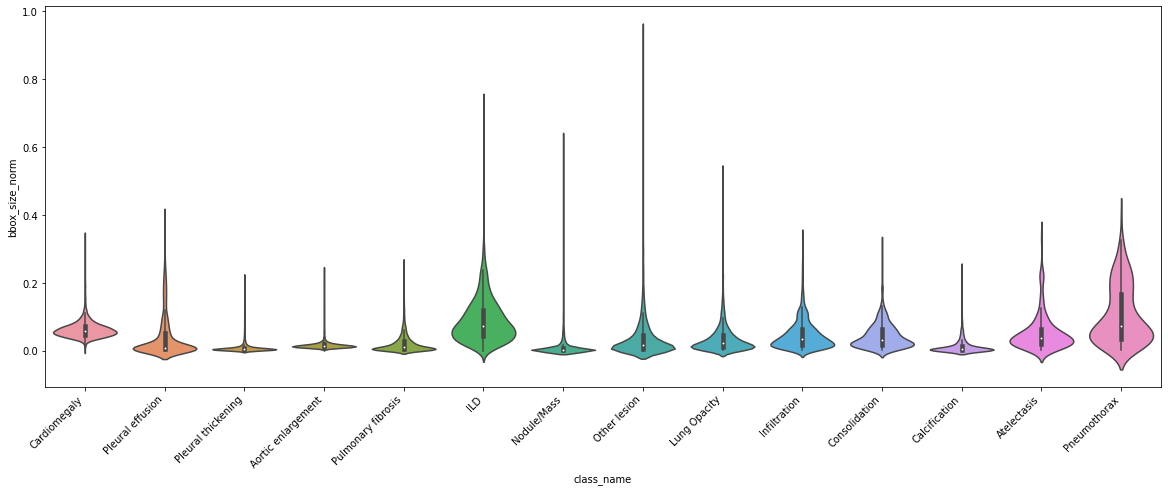

In [ ]:
box_sizes = train_data_abnormal.copy()

box_sizes[["x_min_norm", "x_max_norm"]] = box_sizes[["x_min", "x_max"]].div(box_sizes["dim0"], axis=0)
box_sizes[["y_min_norm", "y_max_norm"]] = box_sizes[["y_min", "y_max"]].div(box_sizes["dim1"], axis=0)
box_sizes[["bbox_width_norm", "bbox_height_norm"]] = box_sizes[["x_max_norm", "y_max_norm"]] - box_sizes[["x_min_norm", "y_min_norm"]].values
box_sizes["bbox_size_norm"] = box_sizes["bbox_width_norm"] * box_sizes["bbox_height_norm"]

_, ax = plt.subplots(figsize=(20, 7))
g = sns.violinplot(data=box_sizes, x="class_name", y="bbox_size_norm", scale="width", ax=ax)
_ = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
box_sizes[box_sizes["bbox_size_norm"] > 0.6].head()

* Seems like some of the diseases (ILD, Nodule/Mass, Other lesion) tend to have bbox sizes close to 1, so a radiologist could probably label the entire image containing small instances of the disease.

### Bbox aspect ratios distributions

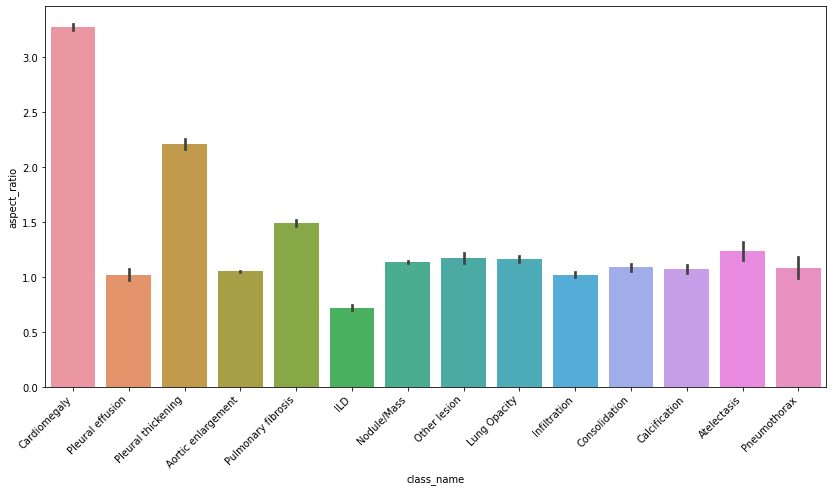

In [ ]:
bbox_aspect_ratios = box_sizes.copy()
bbox_aspect_ratios["aspect_ratio"] = bbox_aspect_ratios["bbox_width_norm"] / bbox_aspect_ratios["bbox_height_norm"]
_, ax = plt.subplots(figsize=(14, 7))
g = sns.barplot(data=bbox_aspect_ratios, x="class_name", y="aspect_ratio")
_ = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

* Cardiomegaly and Pleural thickening are usually wider than higher (aspect ratios > 1.7). 
* ILD is usually higher than wider (aspect ratio closer to 0.5).
* Other diseases are closer to square aspect ratio.

### Heatmaps for where each disease is located

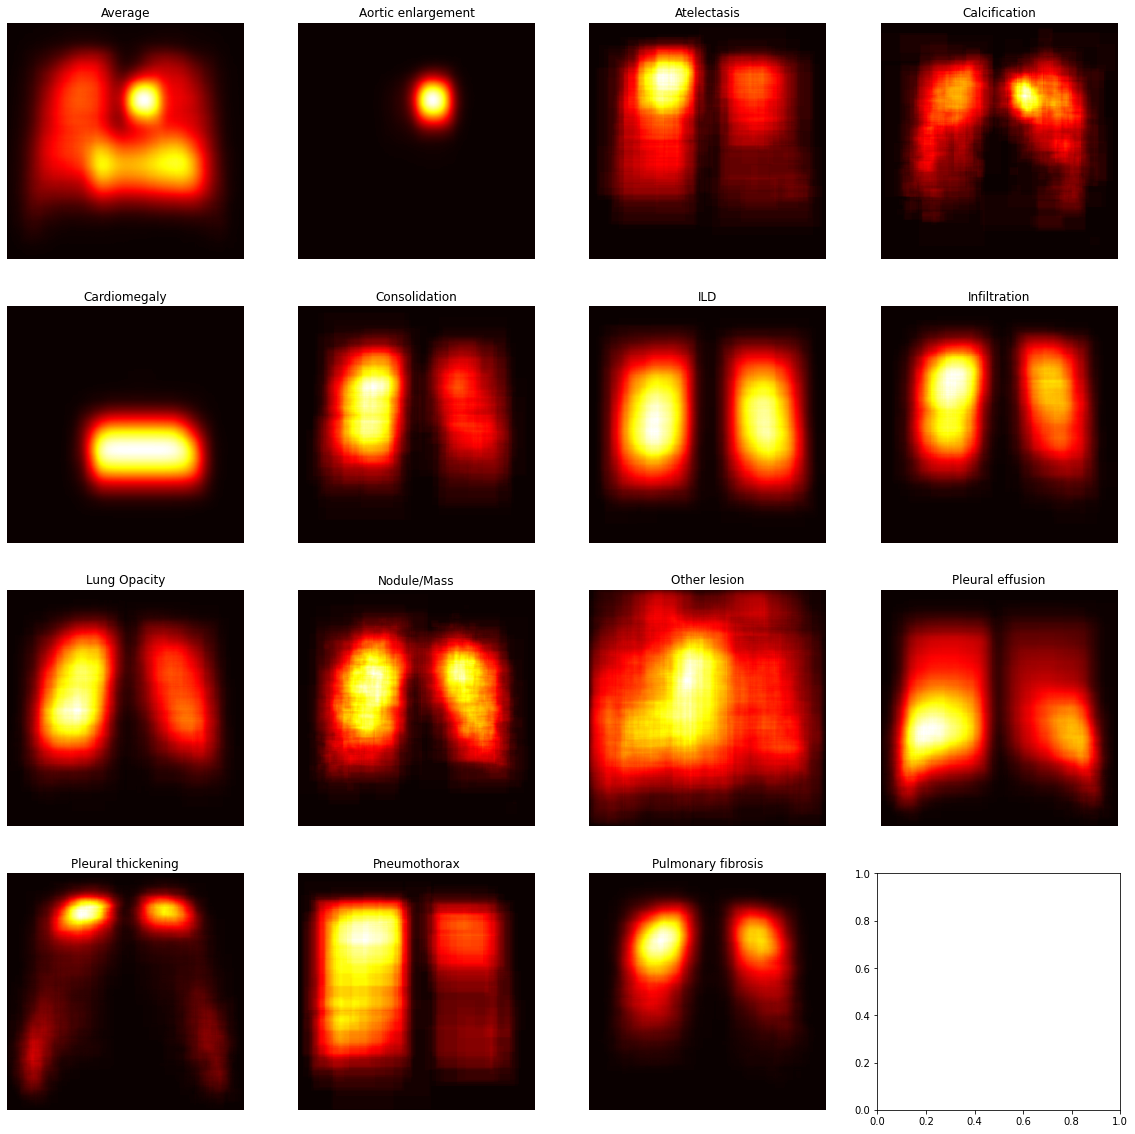

In [ ]:
from tqdm.notebook import tqdm

HEATMAP_SIZE = (256, 256)
heatmaps = np.zeros(HEATMAP_SIZE + (14, ))

box_sizes_hm = box_sizes.copy()
box_sizes_hm[["x_min", "x_max"]] = (box_sizes_hm[["x_min_norm", "x_max_norm"]] * HEATMAP_SIZE[0]).astype("int32")
box_sizes_hm[["y_min", "y_max"]] = (box_sizes_hm[["y_min_norm", "y_max_norm"]] * HEATMAP_SIZE[1]).astype("int32")
box_sizes_hm["class_id"] = pd.to_numeric(box_sizes_hm["class_id"])

for _, row in tqdm(box_sizes_hm.iterrows(), total=len(box_sizes)):
    heatmaps[row["y_min"]:row["y_max"] + 1, row["x_min"]:row["x_max"] + 1, row["class_id"]] += 1

_, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.reshape(-1)
for i in range(heatmaps.shape[-1] + 1):
    cur_heatmap = heatmaps[:, :, i-1] if i > 0 else heatmaps.mean(axis=-1)
    cur_class = class_name_map[i - 1] if i > 0 else "Average"

    ax[i].imshow(cur_heatmap, cmap="hot")
    ax[i].set_title(cur_class)
    ax[i].axis("off")

* Aortic enlargement: almost near the centre of the X-Ray, which makes sense since it's the location of the aorta.
* Atelectasis: mostly in the upper left part of the lungs, although could be throughout the lungs.
* Calcification: throughout the lungs, but mostly in the upper part.
* Cardiomegaly: concentrated in the lower half near the centre.
* Consolidation: throughout the lungs, but mainly on the left.
* ILD: equally throughout the lungs.
* Infiltration: equally throughout the lungs, with some emphasis on the left.
* Lung opacity: equally throughout the lungs, with more emphasis on the left.
* Nodule/Mass: throughout the lungs.
* Other lesion: throughout the X-Ray.
* Pleural effusion: in the lower parts of the lungs with emphasis on the left.
* Pleural thickening: mostly on the upper border of the lungs, and somewhat on the sides.
* Pneumothorax: throughout the lungs, mostly on the left.
* Pulmonary fibrosis: mostly in the upper half of the lungs, with emphasis on the left.

## Images exploration

In [ ]:
TRAIN_IMAGES_DIR = os.path.join(INPUT_FOLDER_DATA, "train")
train_images = os.listdir(TRAIN_IMAGES_DIR)

### Look into dicoms and their additional data

In [ ]:
!pip install pydicom
clear_output()

In [ ]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(data, dicom)

    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    data -= np.min(data)
    data /= np.max(data)
    data *= 255

    return data.astype(np.uint8), dicom

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(im_idx=widgets.IntSlider(min=0, max=len(train_images)-1, step=1, value=0, continuous_update=False))
def display_xray(im_idx):
    image, dicom = read_xray(os.path.join(TRAIN_IMAGES_DIR, train_images[im_idx]))

    plt.rcParams["font.family"] = "monospace"
    _, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(image, "gray")

    ax[1].axis("off")
    for idx, key in enumerate(dicom.keys()):
        ax[1].text(0, 0.95 - idx * 0.02, f"{dicom[key].name:<40}: {'...' if dicom[key].keyword == 'PixelData' else dicom[key].value}")

interactive(children=(IntSlider(value=0, continuous_update=False, description='im_idx', max=9), Output()), _do…

### Look into annotated images

In [ ]:
import cv2

def display_annotated_image(data, image_id, ax, ax_orig):
    print(image_id)

    cur_image_data = data[data["image_id"] == image_id]
    cur_image_path = os.path.join(INPUT_FOLDER_PNG, "train", f"{image_id}.png")

    image = cv2.imread(cur_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ax_orig.imshow(image)
    ax_orig.axis(False)
    ax_orig.set_title("Original")

    abnormalities = set()
    colours = {}
    for _, annot in cur_image_data.iterrows():
        cur_class = annot["class_name"]
        if cur_class == "No finding":
            continue

        abnormalities.add(cur_class)

        if cur_class not in colours:
            # Random colour for each type of abnormality
            colours[cur_class] = list(np.random.random(3) * 256)

        bbox_top_left = (int(annot["x_min"]), int(annot["y_min"]))
        bbox_bottom_right = (int(annot["x_max"]), int(annot["y_max"]))

        image = cv2.rectangle(image, bbox_top_left, bbox_bottom_right, colours[cur_class], 4)

        image = cv2.putText(image, f"{annot['rad_id']} - {cur_class[:10]}".upper(), (bbox_top_left[0], bbox_top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, colours[cur_class], 4)

    ax.imshow(image)
    ax.axis(False)
    ax.set_title(f"{image_id}{' - No finding' if len(abnormalities) == 0 else ''}")

    for abnormality in abnormalities:
        ax.plot([], [], ' ', label=abnormality)
    leg = ax.legend(facecolor="gray")
    for abnormality in leg.get_texts():
        cur_color = list(np.array(colours[abnormality.get_text()]) / 256.0)
        plt.setp(abnormality, color=cur_color)

In [ ]:
images_sample = train_data["image_id"].sample(20, random_state=0).to_numpy()

@interact(im_idx=widgets.IntSlider(min=0, max=len(images_sample)-1, step=1, value=0, continuous_update=False))
def display_sample_image(im_idx):
    _, ax = plt.subplots(1, 2, figsize=(25, 15))
    display_annotated_image(train_data, images_sample[im_idx], ax[0], ax[1])

interactive(children=(IntSlider(value=0, continuous_update=False, description='im_idx', max=19), Output()), _d…

From a few samples not only different radiologists could create different size bounding boxes, but also they could assign different labels to the boxes (Nodule/Mass vs Lung Opacity, etc.).

## Disease information

### Summary on each abnormality

Extra reading:
- https://www.kaggle.com/dschettler8845/visual-in-depth-eda-vinbigdata-competition-data
- https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities

In [ ]:
pd.set_option("display.max_colwidth", None)
pathologies_info = pd.read_csv("vinbigdata-chest-xray-abnormalities-detection/pathologies.csv")
pathologies_info = pathologies_info.dropna().sort_values(by="Label ID")
pathologies_info["Label ID"] = pathologies_info["Label ID"].astype("int32")
pathologies_info = pathologies_info.style.set_properties(**{"text-align": "left"}) 
display(pathologies_info)
pd.reset_option("display.max_colwidth")

,Type,Label ID,Pathology,Definition
0,Local,0,Aortic enlargement,An abnormal bulge that occurs in the wall of the major blood vessel.
1,Local,1,Atelectasis,Collapse of a part of the lung due to a decrease in the amount of air in the alveoli resulting in volume loss and increased density.
3,Local,2,Calcification,Deposition of calcium salts in the lung.
2,Local,3,Cardiomegaly,"Enlargement of the heart, occurs when the heart of an adult patient is larger than normal and the cardiothoracic ratio is greater than 0.5."
5,Local,4,Consolidation,"Any pathologic process that fills the alveoli with fluid, pus, blood, cells (including tumor cells) or other substances resulting in lobar, diffuse or multifocal ill-defined opacities."
9,Local,5,Interstitial lung disease (ILD),Involvement of the supporting tissue of the lung parenchyma resulting in fine or coarse reticular opacities or small nodules.
10,Local,6,Infiltration,"An abnormal substance that accumulates gradually within cells or body tissues or any substance or type of cell that occurs within or spreads as through the interstices (interstitium and/or alveoli) of the lung, that is foreign to the lung, or that accumulates in greater than normal quantity within it."
13,Local,7,Lung opacity,"Any abnormal focal or generalized opacity or opacities in lung fields (blanket tag including but not limited to consolidation, cavity, fibrosis, nodule, mass, calcification, interstitial thickening, etc.)."
15,Local,8,Nodule/Mass,Any space occupying lesion either solitary or multiple.
21,Local,9,Other lesion,Other lesions that are not on the list of findings or abnormalities mentioned above.


## Submission format

In [ ]:
submission_sample = pd.read_csv(os.path.join(INPUT_FOLDER_DATA, "sample_submission.csv"))
submission_sample.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1


## Links
- Paper on data collection by VinBigData: http://www.arxiv-vanity.com/papers/2012.15029/
- More on available dicom tags and their parsing: https://github.com/vinbigdata-medical/vindr-cxr